# Multiple Try Metropolis Independent Sampler algorithm

The given multiple try Metropolis algorith was modified in order to implement the Multiple Try Metropolis Independent Sampled (MTMIS).
On MTMIS, the trial points ($\{\dots, y_j, \dots\}$ or `y_trials`) don't depend on the current state of the Markov Chain ($x$), they are generated by a predefined Gaussian probability distribution ($p( )$ or `trial_distribution`).
Then, a single $y$ value is drawn from the `y_trials` with probability proportional to the weight $w(y_j)$, where

$$ w(y_j) = \frac{\pi(y_j)}{p(y_j)} $$

and

$$ W = \sum_{j=1}^k w(y_j). $$

Then a new step on the Markov chain ($x^{(t + 1)}$) is accepted with probability of 

$$  r_g = \min \left\{  1, \frac{W}{W - w(y) - w(x)} \right\}. $$ 

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

## Define target PDF function

In [2]:
LAM = 12

def target_pdf(x):
    """
    Target PDF of vector x

    Parameters
    ----------
    x : 1d-array or 2d-array
        Array containing the horizontal and vertical component of one or several
        vectors.

    Returns
    -------
    target_pdf : float or 1d-array
        Target PDF of vector(s) x.
    """
    # Convert the argument into 2d-array in order to make this function capable of
    # computing probabilities for multiple vectors
    x = np.atleast_2d(x)
    x1 = x[:, 0]
    x2 = x[:, 1]
    return np.exp(-(x1 ** 2 + x2 ** 2 + (x1 * x2) ** 2) - 2 * LAM * x1 * x2 / 2)

## Define parameters and trial probability distribution

In [3]:
iterations = int(1e4)  # number of iterations
n_trials = 20  # number of trials

In [4]:
# Define trial probability distribution as a Gaussian
sigma = 3  # standard deviation for the trial distribution
trial_distribution = multivariate_normal(
    mean=np.zeros(2), cov=sigma * np.identity(2)
)

## Run MTMIS

In [5]:
# Initialize arrays for sampled points and starting vector x
sampled_points = np.empty((iterations, 2))
x = np.array([0, 0])

# Perform MTMIS
for i in range(iterations):
    
    # Draw independent y_trials given by the predefined Gaussian distribution
    y_trials = trial_distribution.rvs(n_trials)
    # Compute the ratio between likelihood and trial probabilities for each element of
    # y_trials
    weights = target_pdf(y_trials) / trial_distribution.pdf(y_trials)
    # Select y among the y_trials with probability of the weights
    # I have to normalize the probabilities in order to sum one
    index = np.random.choice(n_trials, p=weights / weights.sum())
    y = y_trials[index]

    # Compute the weight for x
    weight_x = target_pdf(x) / trial_distribution.pdf(x)
    # Compute the probability that will be used to accept or reject y
    r_g = min(1, weights.sum() / (weights.sum() - weights[index] + weight_x))
    # Lets accept y with probability r_g
    if r_g > np.random.rand():
        x = y
    sampled_points[i, :] = x

## Plot results

In [6]:
# Compute target PDF to generate contour plot
x1 = np.linspace(-4, 4, 101)
x1, x2 = np.meshgrid(x1, x1)
target = target_pdf(np.hstack((x1[:, np.newaxis], x2[:, np.newaxis])))
target = target.reshape(x1.shape)

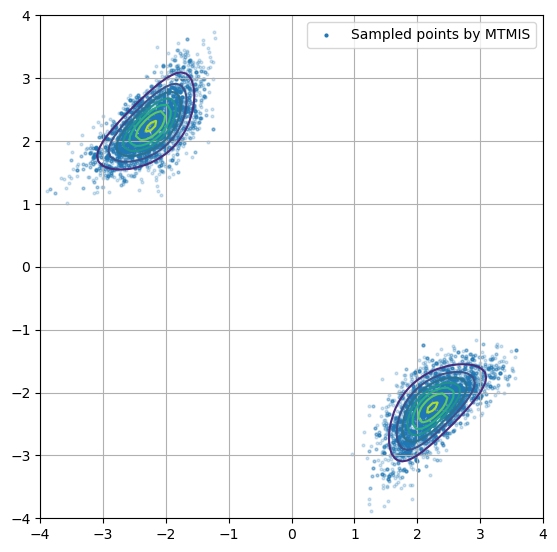

In [7]:
fig, ax = plt.subplots(figsize=(6.66, 6.66), dpi=100)

ax.contour(x1, x2, target)
ax.scatter(
    sampled_points[:, 0],
    sampled_points[:, 1],
    s=4,
    alpha=0.2,
    label="Sampled points by MTMIS",
)
ax.set_aspect("equal")
ax.grid()
legend = ax.legend()
for symbol in legend.legendHandles:
    symbol.set_alpha(1)  # make legend symbol non-transparent
plt.show()

## Conclusions

- The MTMIS is capable of sampling the two maximums of the target PDF as well as the MTM algorithm does.
- We should be careful when choosing the standar deviation for the trial probability distribution. If it's too small, then the y_trials may not reach neither of the maximums of the PDF. On the other hand, if it's too big, the MTMIS will probably need a lot of iterations in order to get a good sampling.